In [ ]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import random

In [390]:
class Item():
    profit = 0
    weight = 0
    def __init__(self, profit, weight):
        self.weight = weight
        self.profit = profit
    def setProfit(self,p):
        self.profit=p
    def setWeight(self,w):
        self.weight = w
    def show_item(self):
        print("Profit: ",self.profit," Weight: ",self.weight)

class Knapsack:
    def __init__(self):
        self.weights = []
        self.capacity = 0
        self.nbItems = 0
        self.items = []

    def setNbItems(self, nb):
        self.nbItems = nb

    def setCapacity(self, cap):
        self.capacity = cap

    def addItem(self, profit, weight):
        self.items.append(Item(profit, weight))
        self.weights.append(weight)

    


In [5]:
# Read the data
def read_data(filename):
    f = open(filename, "r")
    lines = f.readlines()
    knapsack = Knapsack()
    nbItemLine = lines[3].strip().split()
    knapsack.setNbItems(int(nbItemLine[1]))
    capacityLine = lines[4].strip().split()
    knapsack.setCapacity(int(capacityLine[1]))
    data = lines[7:]
    for line in data:
        values = line.strip().split()
        knapsack.addItem(int(values[1]), int(values[2]))
    f.close()
    return knapsack

knapsack_instance = read_data("Data/pi-12-10000-1000-001.kna")
        
for elem in knapsack_instance.items:
        elem.show_item()

print("Nb Items: ", knapsack_instance.nbItems)
print("Capacity: ", knapsack_instance.capacity)

Profit:  582  Weight:  582
Profit:  194  Weight:  194
Profit:  679  Weight:  679
Profit:  485  Weight:  485
Profit:  312  Weight:  396
Profit:  873  Weight:  873
Profit:  468  Weight:  594
Profit:  208  Weight:  264
Profit:  364  Weight:  462
Profit:  260  Weight:  330
Profit:  582  Weight:  582
Profit:  388  Weight:  388
Profit:  291  Weight:  291
Profit:  104  Weight:  132
Profit:  520  Weight:  660
Profit:  416  Weight:  528
Profit:  970  Weight:  970
Profit:  260  Weight:  330
Profit:  582  Weight:  582
Profit:  364  Weight:  462
Profit:  776  Weight:  776
Profit:  194  Weight:  194
Profit:  468  Weight:  594
Profit:  970  Weight:  970
Profit:  312  Weight:  396
Profit:  260  Weight:  330
Profit:  156  Weight:  198
Profit:  485  Weight:  485
Profit:  416  Weight:  528
Profit:  364  Weight:  462
Profit:  582  Weight:  582
Profit:  388  Weight:  388
Profit:  468  Weight:  594
Profit:  679  Weight:  679
Profit:  52  Weight:  66
Profit:  156  Weight:  198
Profit:  312  Weight:  396
Pro

In [408]:
def EstSolutionValide(solution,SacADos):
    # Fonctions pour checker si une solution est valide ou non
    capacity = SacADos.capacity
    total_capacity = 0
    for i in range(SacADos.nbItems):
        total_capacity+=solution[i]*SacADos.items[i].weight
        if(total_capacity>capacity):
            return False
    return True
# def reparer_solution(solution, SacADos):
#     # Fonctions pour réparer une solution en enlever aléatoirement des items
#     capacity = SacADos.capacity
#     selected_indices = np.flatnonzero(solution)
#     weights = np.array(SacADos.weights.copy()) # → NumPy array of weights
#     total_capacity = np.sum(weights[selected_indices])        # → Fast and correct
#     if total_capacity <= capacity:
#         return solution
#     shuffled_indices = np.random.permutation(selected_indices)
#     for idx in shuffled_indices:
#         solution[idx] = 0
#         total_capacity -= SacADos.items[idx].weight
#         if total_capacity <= capacity:
#             break
#     return solution
def reparer_solution(solution, SacADos):
    # Fonctions pour réparer une solution en enlever aléatoirement des items
    capacity = SacADos.capacity
    total_capacity = sum(SacADos.items[i].weight for i, val in enumerate(solution) if val)
    while total_capacity > capacity:
        selected_indices = [i for i, x in enumerate(solution) if x == 1]
        remove_index = random.choice(selected_indices)
        solution[remove_index] = 0
        total_capacity -= SacADos.items[remove_index].weight
    return solution
def calculer_solution(solution,SAD):
    return sum(SAD.items[i].profit for i, val in enumerate(solution) if val)
def calculer_fitness(solutions,SAD):
    # Fonction pour retourner un tableau de fitness des solutions
    return [calculer_solution(sol,SAD) for sol in solutions]
def calculer_fitness_fast(solutions, SAD):
    return np.dot(solutions, np.array([item.profit for item in SAD.items]))  # Vectorized dot product
def select_best_solution(solutions, fitness, n_best=1):
    # Fonction pour séléctioner les meilleurs solutions
    solutions_with_fitness = list(zip(solutions, fitness))
    solutions_with_fitness.sort(key=lambda x: x[1], reverse=True)
    best_solutions = [sol for sol, fit in solutions_with_fitness[:n_best]]
    return best_solutions


In [427]:
def selection_roulette_nfois(solutions,fitness,n):
    # Fonctions pour selections de n nouvelles solutions par tournant n fois la roulette
    total_fitness = sum(fitness)
    selected = []
    for _ in range(n):
        random_fitness = random.uniform(0,total_fitness)
        somme_fitness = 0
        for i,f in enumerate(fitness):
            somme_fitness+=f
            if somme_fitness>= random_fitness:
                selected.append(solutions[i])
                break
    return selected
def selection_roulette_1fois(solutions,fitness,n):
    # Fonctions pour selections de n nouvelles solutions par tournant 1 fois la roulette
    totalfitness = sum(fitness)
    selected = []
    step = totalfitness/n
    start = random.uniform(0, step)
    pointers = [start + i * step for i in range(n)]
    somme_fitness = 0
    index = 0
    for ptr in pointers:
        while somme_fitness < ptr:
            somme_fitness += fitness[index]
            index += 1
        selected.append(solutions[index - 1])
    return selected
def creation_population_initiale(SAD, n):
    Nsol = []
    for _ in range(n):
        sol = np.zeros(SAD.nbItems, dtype=int)  # Initialise une solution avec des 0
        poids_total = 0
        indices = np.random.permutation(SAD.nbItems)  # Mélange les indices des objets
        for idx in indices:
            if poids_total + SAD.items[idx].weight <= SAD.capacity:  # Vérifie si l'objet peut être ajouté
                sol[idx] = 1
                poids_total += SAD.items[idx].weight
            if random.random() < 1/5:  
                break
        Nsol.append(sol)
    return Nsol
def croisement_simple(solutions):
    enfants = []
    for i in range(0, len(solutions), 2):
        if i + 1 < len(solutions):  # Si paire
            parent1 = solutions[i]
            parent2 = solutions[i + 1]
            milieu = len(parent1) // 2  # Point de croisement au milieu
            enfant1 = np.concatenate((parent1[:milieu], parent2[milieu:]))
            enfant2 = np.concatenate((parent2[:milieu], parent1[milieu:]))
            enfants.extends(mutation_unique([enfant1, enfant2]))
            
    return enfants
def croisement_Npoints(solutions, Npoints=2,taux_mutation=100):
    enfants = []
    
    for i in range(0, len(solutions), 2):
        if i + 1 < len(solutions):  # Vérifier qu'il y a bien un pair de parents
            parent1 = solutions[i]
            parent2 = solutions[i + 1]
            longueur = len(parent1)
            # Générer Npoints positions de croisement uniformément réparties
            points = np.linspace(0, longueur, Npoints + 2, dtype=int)[1:-1]  # Évite 0 et len(parent1)
            enfant1, enfant2 = np.copy(parent1), np.copy(parent2)
            swap = False  # Alternance
            # Effectuer le croisement en alternant les segments
            last_idx = 0
            for idx in points:
                if swap:
                    enfant1[last_idx:idx], enfant2[last_idx:idx] = enfant2[last_idx:idx], enfant1[last_idx:idx]
                swap = not swap
                last_idx = idx
            # Appliquer la mutation sur les enfants
            enfant1 = mutation_unique(enfant1,taux_mutation)
            enfant2 = mutation_unique(enfant2,taux_mutation)
            enfants.extend([enfant1, enfant2])
    return enfants

def mutation(solutions):
    if random.randint(1, 100) == 1:  # Probabilité de 1/100
        # Sélectionne une solution au hasard
        index_solution = random.randint(0, len(solutions) - 1)
        solution = solutions[index_solution]
        
        # Sélectionne un élément aléatoire à muter
        index_element = random.randint(0, len(solution) - 1)
        
        # Applique la mutation
        solution[index_element] = 1 - solution[index_element]
        
        # print(f"Mutation appliquée à la solution {index_solution}, élément {index_element}")
    return solutions
def mutation_unique(solution,taux=100):
    if random.randint(1, taux) == 1:  # Probabilité de 1/100
        index_element = random.randint(0, len(solution) - 1)
        solution[index_element] = 1 - solution[index_element]
    return solution

Generation 0: Meilleure solution = 4013
Generation 100: Meilleure solution = 4362
Generation 200: Meilleure solution = 4386
Generation 300: Meilleure solution = 4476
Generation 400: Meilleure solution = 4514
Generation 500: Meilleure solution = 4514


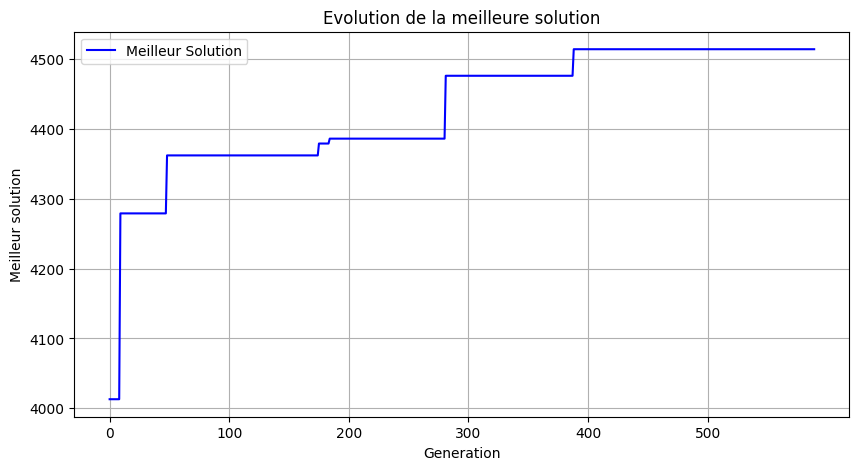

4514
CPU times: total: 5.08 s
Wall time: 5.35 s


In [ ]:
%%time
import numpy as np
import matplotlib.pyplot as plt

SAD = read_data("Data/pi-12-1000-1000-001.kna")
n = (SAD.nbItems // 20) 
u = int(n*0.50)
y = int(n*0.20)
if y<=0: y=1

# Population de départ
Nsol = creation_population_initiale(SAD, n)
fitness = calculer_fitness_fast(Nsol, SAD)
bestKnown = select_best_solution(Nsol, fitness,y)

generations = [0]
best_solutions = []
tempBestSols = [] 

best_G0 = calculer_solution(bestKnown[0], SAD)
best_solutions.append(best_G0)
for gen in range(1000):
    # Roullette biaisée pour la sélection
    Nsol = selection_roulette_1fois(Nsol, fitness, n)

    fitness = calculer_fitness_fast(Nsol, SAD)
    bestKnown = select_best_solution(Nsol, fitness,y)

    tempBestSols = bestKnown[:y] 
    indices_to_remove = []
    indices_to_remove = set() 
    
    # Supprimer les meilleures solutions déjà présentes dans Nsol
    for best in tempBestSols:
        for i, sol in enumerate(Nsol):
            if np.array_equal(sol, best) and i not in indices_to_remove:
                indices_to_remove.add(i)
                break 

    Nsol = np.delete(Nsol, list(indices_to_remove), axis=0)
    # Appliquer le croisement N points
    Nsol = croisement_Npoints(Nsol,u)

    # Réparer les solutions si nécessaire
    for i, sol in enumerate(Nsol):
        Nsol[i] = reparer_solution(sol, SAD)

    Nsol = np.append(Nsol, tempBestSols, axis=0)
    fitness = calculer_fitness_fast(Nsol, SAD)
    best_solution = max(fitness)
    generations.append(gen + 1)
    best_solutions.append(best_solution)
    # Si la meilleure solution n'a pas changé depuis 200 générations, on arrête l'algorithme
    if gen>200:
        if best_solutions[gen-200]==best_solution:
            break
    if gen % 100 == 0:
        print(f"Generation {gen}: Meilleure solution = {best_solution}")
plt.figure(figsize=(10, 5))
plt.plot(generations, best_solutions, linestyle='-', color='b', label="Meilleur Solution")
plt.xlabel("Generation")
plt.ylabel("Meilleur solution")
plt.title("Evolution de la meilleure solution")
step_size = 100
plt.xticks(np.arange(0, generations[-1], step_size))
plt.legend()
plt.grid()
plt.show()
print(max(best_solutions))